# Data Science Capstone Project

Student name: **Cynthia Pedrasa**  
Student pace: **self paced**  
Scheduled project review date/time:  **July 27, 2020 10:00-11:00am**  
Instructor name: **Jeff Herman**  
Blog post URL: https://cpedrasa.github.io/predicting_30-day_all_cause_readmission_from_hospital_discharge_summary

## Table of contents

Introduction: Data Science Framework  

**Model Tuning**
  
I.   Evaluate Algorithms
  + A. <a href="#4a.-Train-Test-Split">Train Test Split</a> 
  + B. <a href="#4b.-Cross-Validation">Cross Validation</a>  
  + C. <a href="#4c.-Evaluation-Metric">Evaluation Metric</a>   

II.    Model Tuning  
  +    <a href="#Tune-max_depth-and-min_child_weight">Tune max_depth and min_child_weight</a>
  +    <a href="#Tune-Gamma">Tune Gamma</a>   
  +    <a href="#Tune-subsample-and-colsample_bytree">Tune subsample and colsample_bytree</a>
  +    <a href="#Tuning-Regularization-Parameters">Tuning Regularization Parameters</a> 
  +    <a href="#Tuning-Learning-Rate ">Tuning Learning Rate </a>
  +    <a href="#Tune-Lambda">Tune Lambda</a>  
  +    <a href="#Tune-the Number-of-Decision Trees">Tune the Number of Decision Trees</a> 


# 1a. Import the Libraries 

In [13]:
import pandas as pd
from pandas import set_option

import numpy as np
from numpy import mean , std, array
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import sqlite3  
from pandas import read_sql_query
import pyodbc
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import os
from os import path
import sys
from glob import glob

import time
from IPython import display
import warnings
warnings.filterwarnings('ignore')
import pickle
import scipy as sp

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict 
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

import string
import re
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.utils import to_categorical
import sklearn.metrics as metrics




## Define the Functions

In [14]:

#Calculate prevalence
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


#Calculate and print scores        
def print_scores(y_test, y_pred):
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import mean_squared_error  
    from sklearn.metrics import r2_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import auc
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve
    from sklearn.metrics import precision_score       
    print("Accuracy: {}".format((accuracy_score(y_test, y_pred).round(decimals=4)*100)),'%')
    print("Precision: {}".format(precision_score(y_test, y_pred)))
    print("Recall: {}".format(recall_score(y_test, y_pred)))
    print("F1-score: {}".format(f1_score(y_test, y_pred)))
    print("R2: {}".format(r2_score(y_test, y_pred)))
    print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
    print("Prevalence: {}".format(calc_prevalence(y_pred)))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.5)))
    print('---------------------------------------------------------------------')
    print('\n','Classification Report:')
    print(classification_report(y_test, y_pred, target_names = ['NO', 'YES']))
    print('---------------------------------------------------------------------')
    # Confusion matrix plot   
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

#plot ROC curve
def plot_roc_curve(y_test, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    auc = roc_auc_score(y_test, model_probs) 
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    print('ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label = 'ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', alpha=.8)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    
def exec_time():                        # record execution time
    execution_time = time.time() - start
    print('Execution time', time.strftime("%H:%M:%S", time.gmtime(execution_time)))

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')                       # remove lines that have ' '
    df.TEXT = df.TEXT.str.replace('\n',' ')             # remove newline characters \n
    df.TEXT = df.TEXT.str.replace('\r',' ')             # remove carriage returns
    return df


# Cleaning, Split by Whitespace, Remove Punctuation, Normalize Case
def clean_tokenize(text):
    # split the string by whitespace and remove punctuation and numbers     
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    # convert all words to lower case
    text = text.lower().translate(t)
    # splitting strings into tokens(words)
    tokens = word_tokenize(text)
    return tokens



[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# 1b. Load the Preprocessed data 

In [15]:
#Load the pre-processed data

df_adm_dcnotes = pd.read_csv('final_data.csv', parse_dates=['ADMITTIME', 'DISCHTIME','NEXT_ADM_DATE','DEATHTIME'])


In [16]:
# shuffle the samples
df_adm_dcnotes = df_adm_dcnotes.sample(n = len(df_adm_dcnotes), random_state = 42)
df_adm_dcnotes = df_adm_dcnotes.reset_index(drop = True)

#Train Test Split

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_dcnotes.sample(frac=0.30,random_state=42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train=df_adm_dcnotes.drop(df_valid_test.index)

# split the training data into positive and negative
rows_pos = df_train.READMITTED == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.READMITTED.sum()/ len(df_train))

# run the above pre-processing function on the train, validation, and test sets
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)



Train prevalence (n = 4248): 0.5


In [17]:
new_stop_words = ['the','and','to','of','was','with','a','on','mg', 'in','for','name',
                 'is','po', 'patient','s','he','blood', 'sig','daily','at','as','or',
                 'one','she','his','her','am','her', 'this', 'date'
                 'were','you','your','pt','pm','by','be','had','this','date', 'q',
                'from','there','an','that','p','c','ct','are','have','has','h','but','o',
                'namepattern','which','every','also','d','x', 'after','fax', 'and', 'are',
                 'further', 'if','it','of','their','those','where','which', 'while', 'who']

# Cleaning, Split by Whitespace, Remove Punctuation, Normalize Case
vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# function to learn a vocabulary from one or more documents
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED



[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# Tuning Model Parameters

##  Tune max_depth and min_child_weight
These have the highest impact on model outcome. We will begin tuning with wider ranges and then we will perform another iteration for smaller ranges.

Grid Search found the following optimal parameters:  0.699366 using {'max_depth': 3, 'min_child_weight': 3}
0.689330 (0.020796) with: {'max_depth': 3, 'min_child_weight': 1}
0.699366 (0.016248) with: {'max_depth': 3, 'min_child_weight': 3}
0.697928 (0.023096) with: {'max_depth': 3, 'min_child_weight': 5}
0.687062 (0.018927) with: {'max_depth': 5, 'min_child_weight': 1}
0.692559 (0.024620) with: {'max_depth': 5, 'min_child_weight': 3}
0.691327 (0.022166) with: {'max_depth': 5, 'min_child_weight': 5}
0.690713 (0.019621) with: {'max_depth': 7, 'min_child_weight': 1}
0.693715 (0.017489) with: {'max_depth': 7, 'min_child_weight': 3}
0.690117 (0.023341) with: {'max_depth': 7, 'min_child_weight': 5}
0.695117 (0.013201) with: {'max_depth': 9, 'min_child_weight': 1}
0.686017 (0.015176) with: {'max_depth': 9, 'min_child_weight': 3}
0.689180 (0.020612) with: {'max_depth': 9, 'min_child_weight': 5}

Training Accuracy: 83.71%
Validation accuracy: 68.06%

Accuracy: 68.06 %
Precision: 0.1224400871459

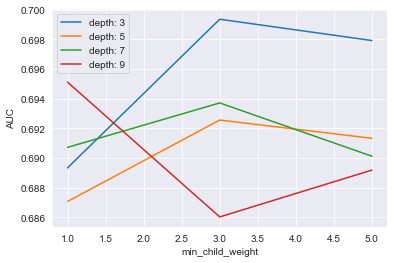

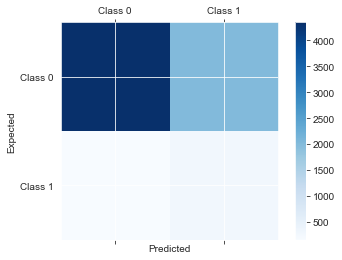

Execution time 00:04:25


In [23]:
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=5,
                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
min_child_weight = range(1,6,2)
max_depth = range(3,10,2)
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

# define evaluation procedure

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(min_child_weight))
for i, value in enumerate(max_depth):
    plt.plot(min_child_weight, scores[i], label='depth: ' + str(value)) 
plt.legend()
plt.xlabel('min_child_weight')
plt.ylabel('AUC') 

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()


Here, we have run 12 combinations with wider intervals between values. The ideal values are 3 for max_depth and 3 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

Grid Search found the following optimal parameters:  0.705111 using {'max_depth': 2, 'min_child_weight': 3}
0.702183 (0.014950) with: {'max_depth': 2, 'min_child_weight': 2}
0.705111 (0.013754) with: {'max_depth': 2, 'min_child_weight': 3}
0.699200 (0.016305) with: {'max_depth': 2, 'min_child_weight': 4}
0.697378 (0.013755) with: {'max_depth': 3, 'min_child_weight': 2}
0.699366 (0.016248) with: {'max_depth': 3, 'min_child_weight': 3}
0.699290 (0.016060) with: {'max_depth': 3, 'min_child_weight': 4}
0.692114 (0.021710) with: {'max_depth': 4, 'min_child_weight': 2}
0.690433 (0.016067) with: {'max_depth': 4, 'min_child_weight': 3}
0.694791 (0.016369) with: {'max_depth': 4, 'min_child_weight': 4}

Training Accuracy: 75.02%
Validation accuracy: 68.9%

Accuracy: 68.89999999999999 %
Precision: 0.12012692656391659
Recall: 0.6050228310502284
F1-score: 0.2004538577912254
R2: -4.158873955371758
MSE: 0.3109738158281848
Prevalence: 0.3245072080023536
Specificity: 0.694811320754717
-----------------

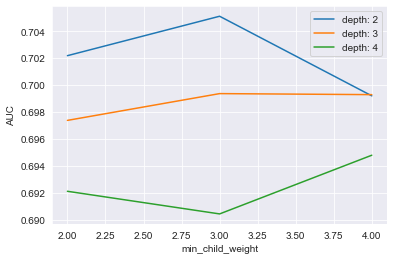

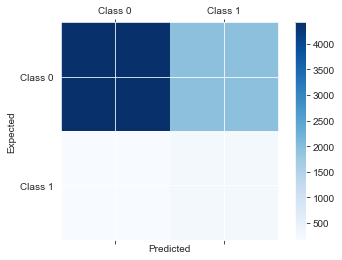

Execution time 00:02:05


In [25]:
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=5,
                      min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
min_child_weight = [2, 3, 4]
max_depth = [2, 3, 4]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(min_child_weight))
for i, value in enumerate(max_depth):
    plt.plot(min_child_weight, scores[i], label='depth: ' + str(value)) 
plt.legend()
plt.xlabel('min_child_weight')
plt.ylabel('AUC') 

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()


Here, we get the optimum values as 2 for max_depth and 3 for min_child_weight. Also, we can see the CV score increasing slightly. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance. You would have noticed that here we got 3 as optimum value for min_child_weight but we haven’t tried values more than 3. We can do that as follow:.

Grid Search found the following optimal parameters:  0.705111 using {'min_child_weight': 3}
0.705111 (0.013754) with: {'min_child_weight': 3}
0.700142 (0.018856) with: {'min_child_weight': 5}
0.697780 (0.013156) with: {'min_child_weight': 7}
0.698477 (0.013890) with: {'min_child_weight': 9}

Training Accuracy: 75.02%
Validation accuracy: 68.9%

Accuracy: 68.89999999999999 %
Precision: 0.12012692656391659
Recall: 0.6050228310502284
F1-score: 0.2004538577912254
R2: -4.158873955371758
MSE: 0.3109738158281848
Prevalence: 0.3245072080023536
Specificity: 0.694811320754717
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.69      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.50      6798
weighted avg       0.91      0.69      0.77      6798

-----

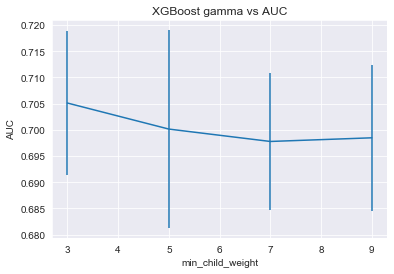

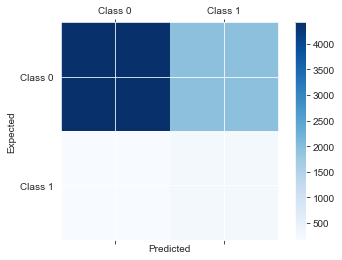

Execution time 00:00:41


In [26]:
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
min_child_weight = [3,5,7,9]

param_grid = dict(min_child_weight=min_child_weight)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

# plot
plt.errorbar(min_child_weight, means, yerr=stds) 
plt.title("XGBoost gamma vs AUC") 
plt.xlabel('min_child_weight')
plt.ylabel('AUC')

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()


min_child_weight =3 is the optimal value

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Tune Gamma

Grid Search found the following optimal parameters:  0.705111 using {'gamma': 0.0}
0.705111 (0.013754) with: {'gamma': 0.0}
0.703787 (0.014546) with: {'gamma': 0.1}
0.703787 (0.014546) with: {'gamma': 0.2}
0.703787 (0.014546) with: {'gamma': 0.3}
0.703787 (0.014546) with: {'gamma': 0.4}

Training Accuracy: 75.02%
Validation accuracy: 68.9%

Accuracy: 68.89999999999999 %
Precision: 0.12012692656391659
Recall: 0.6050228310502284
F1-score: 0.2004538577912254
R2: -4.158873955371758
MSE: 0.3109738158281848
Prevalence: 0.3245072080023536
Specificity: 0.694811320754717
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.69      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.50      6798
weighted avg       0.91      0.69      0.77      6798

---------

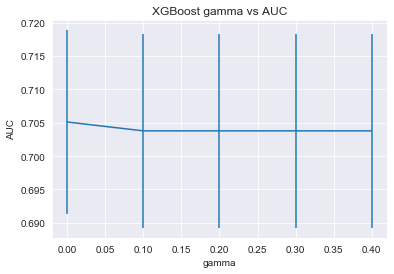

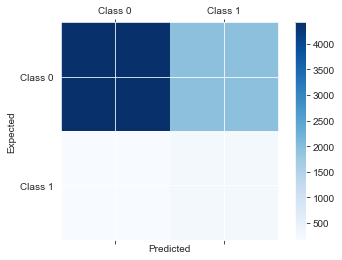

Execution time 00:00:57


In [27]:
#Lets tune gamma value using the parameters already tuned above. 
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(gamma=gamma)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
plt.errorbar(gamma, means, yerr=stds) 
plt.title("XGBoost gamma vs AUC") 
plt.xlabel('gamma')
plt.ylabel('AUC')

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()

In [29]:
# gamma = 0 is the optimal value

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Tune subsample and colsample_bytree

Grid Search found the following optimal parameters:  0.705111 using {'colsample_bytree': 0.8, 'subsample': 0.8}
0.696321 (0.016459) with: {'colsample_bytree': 0.6, 'subsample': 0.6}
0.703114 (0.015856) with: {'colsample_bytree': 0.6, 'subsample': 0.7}
0.699855 (0.016661) with: {'colsample_bytree': 0.6, 'subsample': 0.8}
0.700797 (0.014288) with: {'colsample_bytree': 0.6, 'subsample': 0.9}
0.693858 (0.014949) with: {'colsample_bytree': 0.7, 'subsample': 0.6}
0.704866 (0.019607) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.703214 (0.016277) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.703053 (0.014623) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.696792 (0.014673) with: {'colsample_bytree': 0.8, 'subsample': 0.6}
0.702790 (0.013912) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.705111 (0.013754) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.698310 (0.013169) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.695182 (0.015522) with: {'colsample_bytree': 0

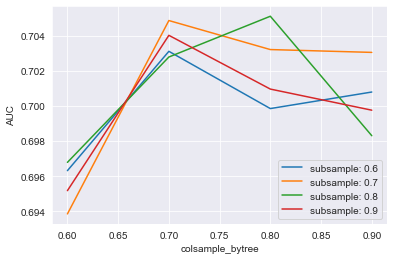

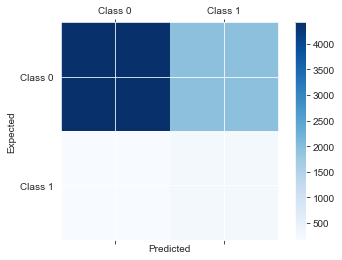

Execution time 00:02:35


In [30]:
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_grid = dict(colsample_bytree=colsample_bytree, subsample=subsample)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(subsample), len(colsample_bytree))
for i, value in enumerate(subsample):
    plt.plot(colsample_bytree, scores[i], label='subsample: ' + str(value)) 
plt.legend()
plt.xlabel('colsample_bytree')
plt.ylabel('AUC') 

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)


exec_time()
#0.689056 using {'colsample_bytree': 0.9, 'subsample': 0.9}

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

Grid Search found the following optimal parameters:  0.705178 using {'colsample_bytree': 0.8, 'subsample': 0.85}
0.703342 (0.016106) with: {'colsample_bytree': 0.75, 'subsample': 0.75}
0.701767 (0.015069) with: {'colsample_bytree': 0.75, 'subsample': 0.8}
0.704933 (0.017234) with: {'colsample_bytree': 0.75, 'subsample': 0.85}
0.700232 (0.018189) with: {'colsample_bytree': 0.8, 'subsample': 0.75}
0.705111 (0.013754) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.705178 (0.014324) with: {'colsample_bytree': 0.8, 'subsample': 0.85}
0.701473 (0.017952) with: {'colsample_bytree': 0.85, 'subsample': 0.75}
0.700190 (0.013412) with: {'colsample_bytree': 0.85, 'subsample': 0.8}
0.703370 (0.015496) with: {'colsample_bytree': 0.85, 'subsample': 0.85}

Training Accuracy: 75.07%
Validation accuracy: 69.05%

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Spe

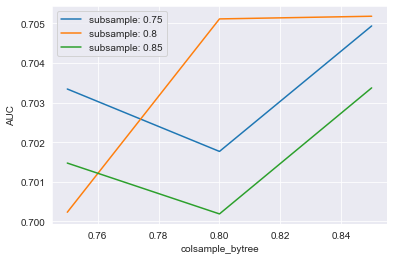

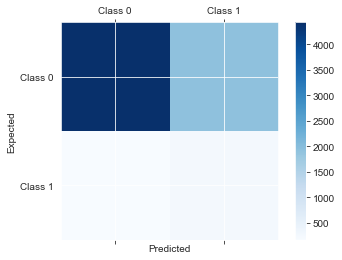

Execution time 00:01:29


In [31]:
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
subsample = [i/100.0 for i in range(75,90,5)]
colsample_bytree = [i/100.0 for i in range(75,90,5)]
param_grid = dict(colsample_bytree=colsample_bytree, subsample=subsample)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(subsample), len(colsample_bytree))
for i, value in enumerate(subsample):
    plt.plot(colsample_bytree, scores[i], label='subsample: ' + str(value)) 
plt.legend()
plt.xlabel('colsample_bytree')
plt.ylabel('AUC') 
    
XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)


exec_time()


The score has slightly improved from the previous case.

The optimum values are:
subsample: 0.85
colsample_bytree: 0.8

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Tuning Regularization Parameters
Apply regularization to reduce overfitting

Grid Search found the following optimal parameters:  0.705178 using {'reg_alpha': 1e-05}
0.705178 (0.014324) with: {'reg_alpha': 1e-05}
0.704403 (0.013743) with: {'reg_alpha': 0.01}
0.703267 (0.016145) with: {'reg_alpha': 0.1}
0.703958 (0.013145) with: {'reg_alpha': 1}
0.645766 (0.014836) with: {'reg_alpha': 100}

Training Accuracy: 75.07%
Validation accuracy: 69.05%

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Specificity: 0.6960691823899371
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.51      6798
weighted avg       0.91      0.69      0.77 

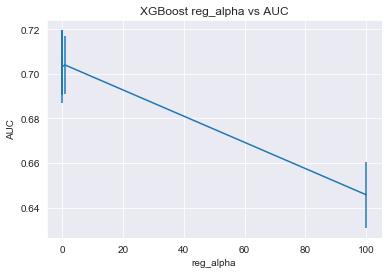

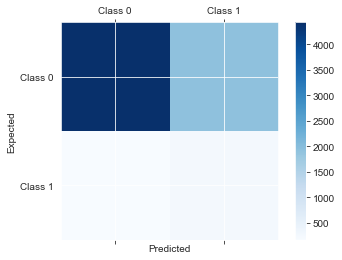

Execution time 00:00:50


In [33]:
#Lets tune the reg_alpha value using the parameters already tuned above. 
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
param_grid = dict(reg_alpha=reg_alpha)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
plt.errorbar(reg_alpha, means, yerr=stds) 
plt.title("XGBoost reg_alpha vs AUC") 
plt.xlabel('reg_alpha')
plt.ylabel('AUC')

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()


We can see that the score is the same as the previous case. But the values tried are very widespread, we should try values closer to the optimum here (0.01) to see if we get something better.

Grid Search found the following optimal parameters:  0.705178 using {'reg_alpha': 0.001}
0.705178 (0.014324) with: {'reg_alpha': 0}
0.705178 (0.014323) with: {'reg_alpha': 0.001}
0.704484 (0.013781) with: {'reg_alpha': 0.005}
0.704403 (0.013743) with: {'reg_alpha': 0.01}
0.699564 (0.015088) with: {'reg_alpha': 0.05}

Training Accuracy: 75.07%
Validation accuracy: 69.05%

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Specificity: 0.6960691823899371
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.51      6798
weighted avg       0.91      0.69      0.

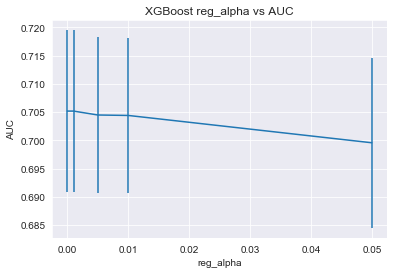

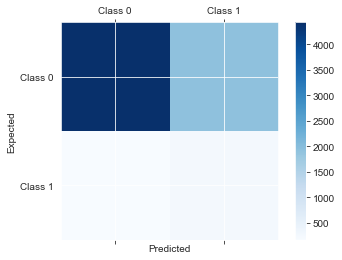

Execution time 00:00:51


In [34]:
#Lets tune the reg_alpha regularization to reduce overfitting
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
reg_alpha = [0, 0.001, 0.005, 0.01, 0.05]
param_grid = dict(reg_alpha=reg_alpha)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
plt.errorbar(reg_alpha, means, yerr=stds) 
plt.title("XGBoost reg_alpha vs AUC") 
plt.xlabel('reg_alpha')
plt.ylabel('AUC')

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()

The optimal reg_alpha is 0.001.

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Tuning Learning Rate 

Grid Search found the following optimal parameters:  0.701375 using {'learning_rate': 0.1, 'n_estimators': 100}
0.641776 (0.014292) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.643033 (0.013394) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.643159 (0.014559) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.645217 (0.013216) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.656580 (0.013974) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.668999 (0.013767) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.688818 (0.013373) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.701375 (0.014488) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.694449 (0.015424) with: {'learning_rate': 0.2, 'n_estimators': 50}
0.693359 (0.016549) with: {'learning_rate': 0.2, 'n_estimators': 100}
0.688097 (0.015546) with: {'learning_rate': 0.3, 'n_estimators': 50}
0.682557 (0.018372) with: {'learning_rate': 0.3, 'n_estimators': 100}
0.621802 (0.018551) with: {'learning_rate'

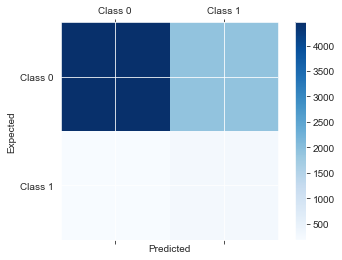

Execution time 00:01:18


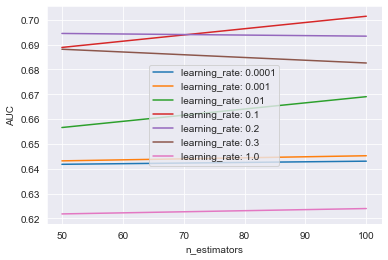

In [36]:
# ⏰ This cell may take a long time to run!
# Tuning Learning Rate and the Number of Trees

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_alpha = 0.001,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.0]
n_estimators = range(50, 150, 50)
param_grid = dict(n_estimators =n_estimators, learning_rate=learning_rate)
# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)
# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value)) 
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('AUC') 


exec_time()



[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

The learning rate remains the same, the n_estimators has changed but the score has decreased from previous case. 

## Tune the Number of Decision Trees

Grid Search found the following optimal parameters:  0.705178 using {'n_estimators': 150}
0.688818 (0.013373) with: {'n_estimators': 50}
0.701375 (0.014488) with: {'n_estimators': 100}
0.705178 (0.014323) with: {'n_estimators': 150}
0.704653 (0.015410) with: {'n_estimators': 200}
0.700121 (0.013946) with: {'n_estimators': 300}

Training Accuracy: 75.07%
Validation accuracy: 69.05%

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Specificity: 0.6960691823899371
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.51      6798
weighted avg       0.91      0

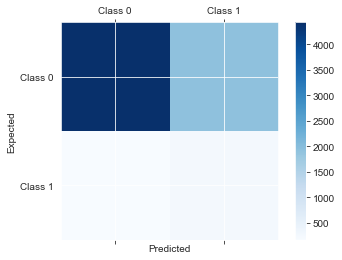

Execution time 00:00:55


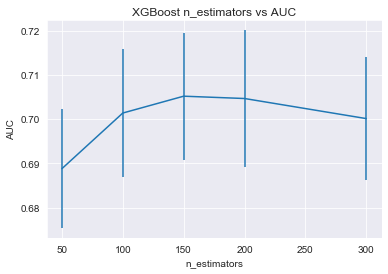

In [40]:
# ⏰ This cell may take a long time to run!
# Tuning Learning Rate and the Number of Trees

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1,  max_depth=2, reg_alpha = 0.001,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# define grid
n_estimators = [50, 100, 150, 200, 300]

param_grid = dict(n_estimators =n_estimators)
# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)
# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

# plot
plt.errorbar(n_estimators, means, yerr=stds) 
plt.title("XGBoost n_estimators vs AUC") 
plt.xlabel('n_estimators')
plt.ylabel('AUC')


exec_time()



The score has improved and so we are keeping the n_estimators at 150.

## Tune Lambda

Grid Search found the following optimal parameters:  0.705178 using {'reg_lambda': 1}
0.700472 (0.014403) with: {'reg_lambda': 0}
0.700270 (0.015282) with: {'reg_lambda': 0.005}
0.700273 (0.015293) with: {'reg_lambda': 0.01}
0.700068 (0.014181) with: {'reg_lambda': 0.05}
0.705178 (0.014323) with: {'reg_lambda': 1}
0.704777 (0.017341) with: {'reg_lambda': 2}

Training Accuracy: 75.07%
Validation accuracy: 69.05%

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Specificity: 0.6960691823899371
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.51      6798

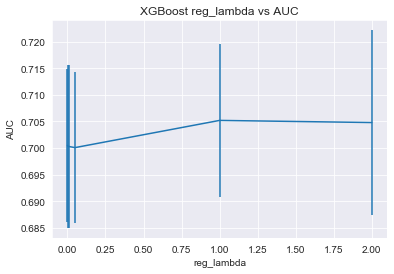

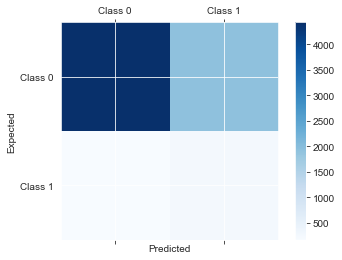

Execution time 00:01:05


In [41]:
#Lets tune the reg_alpha value using the parameters already tuned above. 
# ⏰ This cell may take a long time to run!

start = time.time()

# define model
model = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_alpha = 0.001,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

# define grid
reg_lambda = [0, 0.005, 0.01, 0.05, 1, 2]
param_grid = dict(reg_lambda=reg_lambda)

# define evaluation procedure
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_tf, y_train)

# report the best configuration
print("Grid Search found the following optimal parameters:  %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
plt.errorbar(reg_lambda, means, yerr=stds) 
plt.title("XGBoost reg_lambda vs AUC") 
plt.xlabel('reg_lambda')
plt.ylabel('AUC')

XGBt_train_preds = grid_result.predict(X_train_tf)
XGBt_valid_preds = grid_result.predict(X_valid_tf)
training_accuracy = accuracy_score(y_train, XGBt_train_preds)
validation_accuracy = accuracy_score(y_valid, XGBt_valid_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validation_accuracy * 100))
print('')
print_scores(y_valid, XGBt_valid_preds)
fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_valid, XGBt_valid_preds)

exec_time()

In [44]:
#Let's check the optimal number of features with the updated parameters
start = time.time()

num_features = range(1000, 10000, 1000)
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for i in range(len(num_features)):
    num = num_features[i]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = clean_tokenize,stop_words =new_stop_words)

    # This could take a while
    vect.fit(df_train.TEXT.values)

    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.READMITTED
    y_valid = df_valid.READMITTED
    
    model = XGBClassifier(learning_rate =0.1, n_estimators=150, 
                      max_depth=2, reg_alpha = 0.001, reg_lambda=1,
                      min_child_weight=3, gamma=0.0, subsample=0.85, colsample_bytree=0.8,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)
    
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

exec_time()


number of features: 1000
Train AUC:0.819
Valid AUC:0.691

number of features: 2000
Train AUC:0.830
Valid AUC:0.697

number of features: 3000
Train AUC:0.834
Valid AUC:0.704

number of features: 4000
Train AUC:0.837
Valid AUC:0.700

number of features: 5000
Train AUC:0.836
Valid AUC:0.704

number of features: 6000
Train AUC:0.835
Valid AUC:0.700

number of features: 7000
Train AUC:0.837
Valid AUC:0.707

number of features: 8000
Train AUC:0.837
Valid AUC:0.699

number of features: 9000
Train AUC:0.836
Valid AUC:0.706
Execution time 00:12:44


The optimal number of features is 4000.

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Predict on Validation data

Accuracy: 69.17 %
Precision: 0.12249544626593807
Recall: 0.6141552511415526
F1-score: 0.20425208807896736
R2: -4.114947876281554
MSE: 0.30832597822889085
Prevalence: 0.323036187113857
Specificity: 0.6970125786163522
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.66      0.51      6798
weighted avg       0.91      0.69      0.77      6798

---------------------------------------------------------------------
Confusion matrix:
 [[4433 1927]
 [ 169  269]]


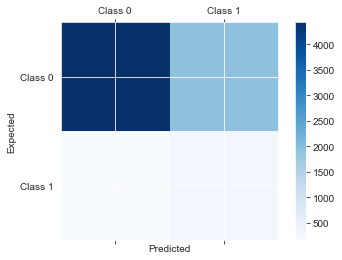

ROC AUC: 0.706


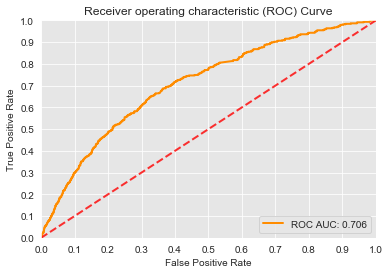

Execution time 00:01:45


In [45]:
start = time.time()

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

# Class Labels
y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)
                                                                                

XGB_probs = XGB.predict_proba(X_valid_tf)[:, 1]              # predict probabilities for the positive outcome only
y_pred = XGB.predict(X_valid_tf)                                                # predict

fpr_XGB, tpr_XGB, thresholds = roc_curve(y_valid, XGB_probs)                    # calculate roc_auc score
XGB_precision, XGB_recall, _ = precision_recall_curve(y_valid, XGB_probs)       # calculate pr_auc score 

#Summary report:
print_scores(y_valid, y_pred)
plot_roc_curve(y_valid, XGB_probs,  'XGB')
    
exec_time()


## Predict on Test data

Accuracy: 67.99 %
Precision: 0.11091626479614204
Recall: 0.6309226932668329
F1-score: 0.18866517524235646
R2: -4.766593364954036
MSE: 0.3200941453368638
Prevalence: 0.33553986466607827
Specificity: 0.6829763951852431
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.97      0.68      0.80      6397
         YES       0.11      0.63      0.19       401

    accuracy                           0.68      6798
   macro avg       0.54      0.66      0.49      6798
weighted avg       0.92      0.68      0.76      6798

---------------------------------------------------------------------
Confusion matrix:
 [[4369 2028]
 [ 148  253]]


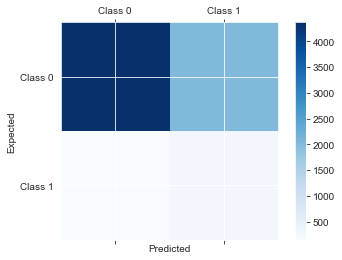

ROC AUC: 0.708


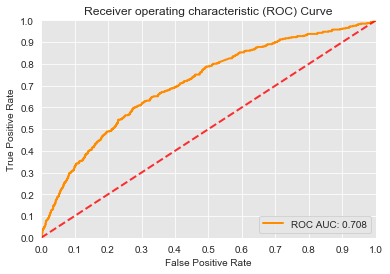

Execution time 00:02:00


In [47]:
start = time.time()

vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# fit to learn the vocabulary
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)
# Class Labels
y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)
                                                                                                     
XGB_probs = XGB.predict_proba(X_test_tf)[:, 1]              # predict probabilities for the positive outcome only
y_pred = XGB.predict(X_test_tf)                                                # predict

fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, XGB_probs)                    # calculate roc_auc score
XGB_precision, XGB_recall, _ = precision_recall_curve(y_test, XGB_probs)       # calculate pr_auc score 

#Summary report:
print_scores(y_test, y_pred)
plot_roc_curve(y_test, XGB_probs,  'XGB')  

exec_time()

Train prevalence(n = 4248): 0.500
Valid prevalence(n = 6798): 0.064
Test prevalence(n = 6798): 0.059
Train AUC:0.837
Valid AUC:0.700
Test AUC:0.708
Train accuracy:0.751
Valid accuracy:0.690
Test accuracy:0.680
Train recall:0.691
Valid recall:0.610
Test recall:0.631
Train precision:0.785
Valid precision:0.121
Test precision:0.111
Train specificity:0.811
Valid specificity:0.696
Test specificity:0.683


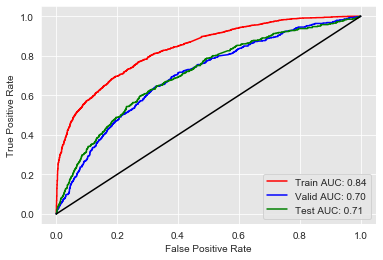

Execution time 00:02:05


In [48]:
#Let's fit the model to the test set and compare the model performance
## ⏰ This cell may take a long time to run!
start = time.time()

vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# fit to learn the vocabulary
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)                           

XGB.fit(X_train_tf, y_train)

model = XGB
y_train_pred = model.predict_proba(X_train_tf)[:,1]
y_valid_pred = model.predict_proba(X_valid_tf)[:,1]
y_test_pred = model.predict_proba(X_test_tf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_pred)
auc_valid = roc_auc_score(y_valid, y_valid_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_pred, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_pred, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_pred, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_pred, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_pred, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_pred, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_pred, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_pred, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_pred, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_pred, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_pred, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_pred, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

exec_time()


### Inspect the Learning Curve

Accuracy: 69.05%


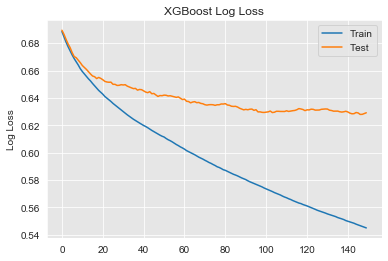

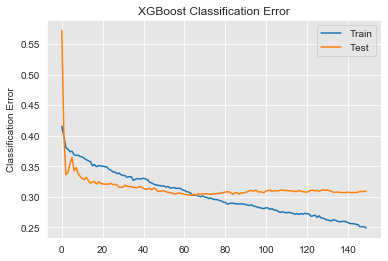

In [49]:
# Inspect the Learning Curve
eval_set = [(X_train_tf, y_train), (X_valid_tf, y_valid)]
model.fit(X_train_tf, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
predictions = model.predict(X_valid_tf)
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model.evals_result()
epochs = len(results['validation_0']['error']) 
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train') 
ax.plot(x_axis, results['validation_1']['logloss'], label='Test') 
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train') 
ax.plot(x_axis, results['validation_1']['error'], label='Test') 
ax.legend()
plt.ylabel('Classification Error') 
plt.title('XGBoost Classification Error') 
plt.show()